# Bayesian Optimization

With this project I am trying to get a better understanding of Bayesian optimization and Gaussian processes. For this purpose I wrote a naive implementation of a Gaussian Process used inside a custom Bayesian Optimization Class.
As a simple implementation task I chose to use weather data from the
<a href="https://www.dwd.de/EN/climate_environment/cdc/cdc_node.html">German Meteorological Service</a> and the model is a boosted tree using the <a href="https://lightgbm.readthedocs.io/en/latest/index.html">LightGBM library from Microsoft</a>.

First load necessary libraries

In [1]:
# General purpose packages
import os
import contextlib

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import gridspec
from pathlib import Path

# Custom methods for data handling and plotting
from utils import get_nan_inds, OLS, Model, plot_progress, plot_freq

# Custom methods for Bayesian Optimization
from bayesian_optimization import expected_improvement, BayesianOptimization
from kernels import Kernel

# Ax platform
from ax import RangeParameter, ParameterType, SearchSpace, SimpleExperiment
from ax.modelbridge.registry import Models

Set directories

In [2]:
project_dir = Path().resolve()
read_dir = project_dir / 'data' / 'input_data'
save_dir = project_dir / 'data' / 'output_data'

## Data handling

Define functions to read in the data.

In [3]:
@contextlib.contextmanager
def working_directory(path):
    """ Changes working directory and returns to previous on exit.
    Use together with context manager e.g. with():

    path (str or path object): target directory
    """
    prev_cwd = Path.cwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(prev_cwd)
        
def read_data(path, var_name):
    
    colnames = ['id', 'date'] + [var_name]
        
    return pd.read_csv(path, usecols=[1,2,3], index_col=[0, 1], names=colnames,
                       parse_dates=[1], date_parser=date_parser,
                       squeeze=True, header=0)

Read in the data as a pandas DataFrame

In [4]:
date_parser = lambda x: pd.to_datetime(x, format='%Y%m%d%H%M')

file_names = ['data_TT_TU_MN009.csv', 'data_FF_MN008.csv', 'data_R1_MN008.csv', 
              'data_P0_MN008.csv', 'data_D_MN003.csv']
var_names = ['temp', 'wind', 'rain', 'pres', 'coor']

with working_directory(read_dir):
    df = pd.concat([read_data(file_name, var_name) for file_name, var_name in 
                     zip(file_names, var_names)], axis=1)

Define a common date range.

In [5]:
date_range = pd.date_range(start = '1/1/2010 00:00:00', 
                           end = '19/01/2021 23:00:00', 
                           freq = 'H')

station_ids = df.index.unique(0)

ind = pd.MultiIndex.from_product([station_ids, date_range], 
                                 names = ['id', 'date'])

df = pd.DataFrame(index=ind).merge(df, how='left', 
                                   left_index=True, right_index=True)

Indices are station ID and date time.<br>
The data consists of 
<ul>
<li><b>temp:</b> air temperature at 2 m above ground in °C</li>
<li><b>wind:</b> wind velocity 10 m above ground in m/s</li>
<li><b>rain:</b> precipitation amount in mm</li>
<li><b>pres:</b> air pressure at station level in hpa</li>
<li><b>coor:</b> wind direction at ca. 10 m above ground in degree</li>
</ul>

In [6]:
df.head()

temp  wind  rain   pres  coor
id   date                                              
1420 2010-01-01 00:00:00   3.9   2.5   0.1  978.2  30.0
     2010-01-01 01:00:00   3.3   2.5   0.0  978.2  20.0
     2010-01-01 02:00:00   2.9   3.6   0.0  978.4  20.0
     2010-01-01 03:00:00   2.5   3.1   0.0  978.3  20.0
     2010-01-01 04:00:00   2.1   3.2   0.0  978.5  30.0

The goal is to predict the temperature and rain in Frankfurt (ID: 1420) for 6 hours using a standing forecast.

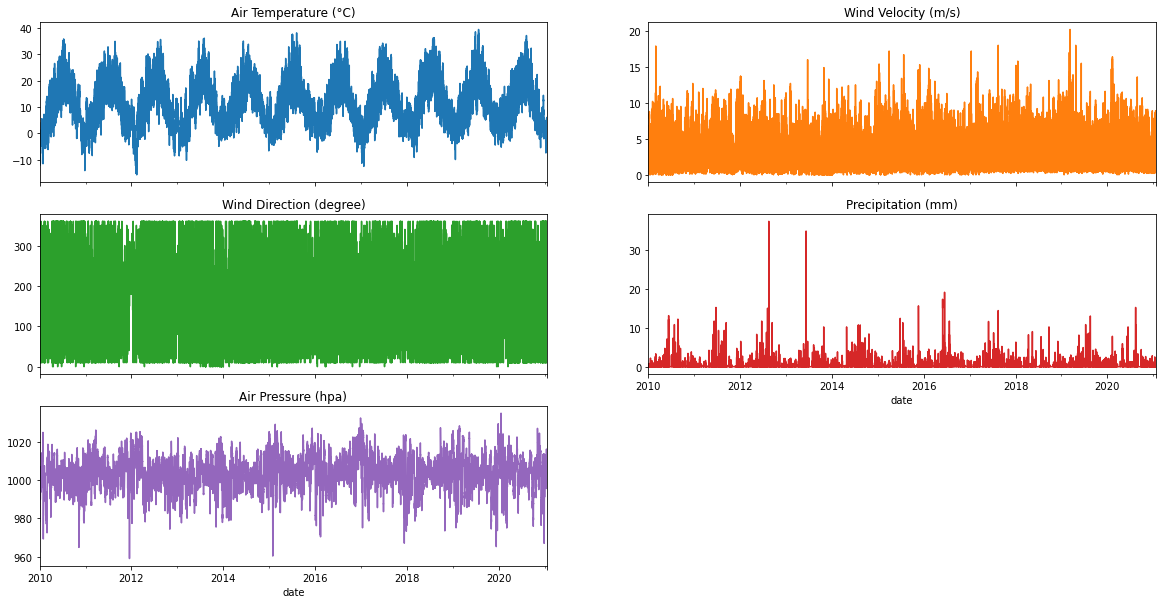

In [7]:
plt.rcParams['figure.constrained_layout.use'] = False
df.loc[(1420, slice(None)),['temp','wind','coor','rain','pres']]\
                             .droplevel(axis=0, level=0)\
                             .plot(figsize = (20,10), subplots = True, 
                                   layout = (3,2), legend = False,
                                   title=['Air Temperature (°C)',
                                          'Wind Velocity (m/s)',
                                          'Wind Direction (degree)',
                                          'Precipitation (mm)',
                                          'Air Pressure (hpa)'])
plt.show()

Converting wind from polar to Cartesian coordinates.

In [8]:
rad = df.pop('coor') * np.pi / 180 # convert degree to radians

df['wind_x'] = df['wind'] * np.cos(rad)
df['wind_y'] = df.pop('wind') * np.sin(rad)

del rad

Perform simple OLS interpolation. <br>


1.   Determine NaN indices.
2.   Create a copy with linear interpolated data.
3.   For each station-variable combination, regress the current variable station pair on the other stations with the same variable. 
4.   Fill the missing data using OLS in-sample predictions.

In [9]:
def ols_interpolation(df):
    ''' Perform interpolation by using OLS of the same variable from other 
    stations at the same date time range. This function is applied using 
    pandas groupby function.
    '''
    df_nan = df.droplevel(axis=0, level=1).T
    df_lin = df_nan.interpolate(axis=0)
    for station_id in df_nan.columns[df_nan.isna().any()]:
        
        X = df_lin.drop(station_id, axis=1).to_numpy()
        y = df_lin.loc[:,station_id].to_numpy()
        
        beta = OLS(X,y)
        
        nan_inds = get_nan_inds(df_nan.loc[:,station_id])
    
        for min_ind, max_ind in nan_inds:
            dates = date_range[min_ind:max_ind]
            df.loc[(station_id, df.name), dates] = X[min_ind:max_ind,:] @ beta
    return df

In [10]:
df = df.stack().unstack(1)
df.index.names = ['id', 'variable']
df = df.groupby(by='variable', axis=0, level=1).apply(ols_interpolation)

Before starting to estimate the main model, the cyclical components can be expressed as Sinusoids. <br>
For this purpose the Fourier transform is used to extract the relevant frequencies.

The most pronounced cycles are 
*   seasonal and daily cycles for Temperature
*   daily cycles for wind_y
*   yearly cycles for wind_x

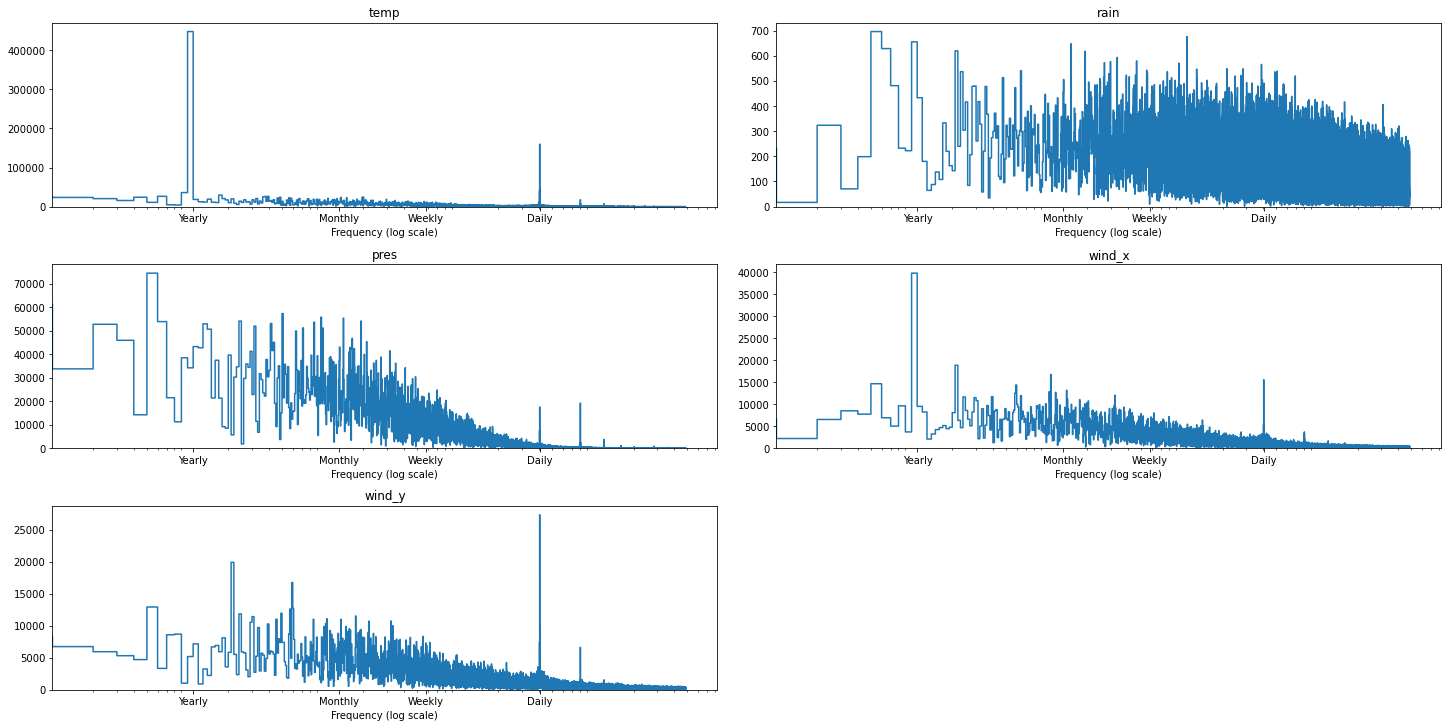

In [11]:
plt.rcParams['figure.constrained_layout.use'] = True
fig = plt.figure(figsize=(20,10))
spec = gridspec.GridSpec(figure=fig, nrows=3, ncols=2)
for i, var in enumerate(df.index.unique(1)):
    ax = fig.add_subplot(spec[i])
    ax.title.set_text(var)
    plot_freq(df.loc[(1420, var),:].to_numpy(), ax=ax)

One can either estimate a separate model for the seasonality (SARIMAX or TBATS) or include sinusoids in the data such that the model can use its own weights.<br>
Here, sine and cosine waves with yearly and daily frequency are included.

In [12]:
hours_per_day = 24
hours_per_year = 365.2425*24
ind = 2 * np.pi * np.arange(len(date_range))

df_seas = pd.DataFrame({('season', 'day_sin') : np.sin(ind / hours_per_day),
                        ('season', 'day_cos') : np.cos(ind / hours_per_day),
                        ('season', 'year_sin') : np.sin(ind / hours_per_year),
                        ('season', 'year_cos') : np.cos(ind / hours_per_year)}, 
                       index = date_range)
df = pd.concat([df, df_seas.T], axis=0)

Split the target and train data

In [13]:
df_target = df.loc[:,'19/01/2021 00:00:00':]
df_train = df.loc[:,:'19/01/2021 00:00:00']
data_mat = df_train.T.to_numpy()

## Modeling

Whenever a model is fitted to data, parameters have to be determined. Most of these are solved by the model itself like coefficients in OLS. But some models have undetermined hyperparameters, which have to be defined outside of the model. One can either use best practice values based on model and application type or search the hyperparameter space systematically. The most simplistic methods are grid search and random search which are inefficient. A more involved practice is to model the hyperparameters themselves using for example Bayesian optimization. This algorithm uses a Gaussian process to approximate the underlying process and determine the next evaluation point by optimizing an acquisition function.<br>
### Gaussian Process
A Gaussian process fits a multivariate Gaussian (Normal) distribution to a given finite number of random variables. This can be shown using a simple linear model 
\begin{align} 
    y &= x^Tw + \epsilon\\
      &= f(x) + \epsilon
\end{align}
where error term is assumed to be iid Normal $\epsilon \overset{iid}{\sim} \mathcal{N}(0, \sigma^2)$. The goal is to find $w$ such that $\epsilon$ is as small as possible.\
Starting of, the weights are assumed to be a multivariate Gaussian i.e.
$$w \sim \mathcal{N}(0,\Sigma) \qquad (prior).$$
In order to get the probability distribution of $w$ given data, Bayes theorem is applied to give rise to the posterior distribution
\begin{align} 
    p(w|y,x) &=\frac{p(y|x,w)p(w)}{p(y|x)}\\
             &\propto p(y|x,w)p(w) \qquad(likelihood \times prior.)\\
             &= \mathcal{N}(x^Tw,\sigma^2\mathbb{I})\mathcal{N}(0,\Sigma)\\
             &=\mathcal{N}(\sigma^{-2}A^{-1}xy,A^{-1})
\end{align}
with $A^{-1}=\sigma^{-2}xx^T+\Sigma^{-1}$.\
This model can then be used to predict function values given past values $(x,y)$ and current suggestions $x_*$. This is done using the predictive distribution, which is a weighted average of all possible $w$ with the posterior as the weights. 
Thus, the conditional probability of the new function values $f_*=f(x_*)$ is
\begin{equation}
    p(f_*|x_*,x,y)=\mathcal{N}(\sigma^{-1}x_*^TA^{-1}xy, x_*^TA^{-1}x_*).
\end{equation}\
Thus far, only a linear model is considered, which can be to simplistic in some cases. When allowing for non-linear functions the inputs $x$ are projected by the function $\phi(x)$ into a higher dimension leading to $$f(x) = \phi(x)^Tw.$$
Now, plugging these values in the predictive distribution we obtain
\begin{align} 
    p(f_*|x_*,x,y) &\sim\mathcal{N}(\sigma^{-1}\phi(x_*)^TA^{-1}\phi(x)y, \phi(x_*)^TA^{-1}\phi(x_*))\\
                   &\sim\mathcal{N}(\phi(x_*)^T\Sigma\phi(x)(\phi(x)^T\Sigma\phi(x)+\sigma^2\mathbb{I})^{-1}y, \\
                   &\qquad\quad \phi(x_*)^T\Sigma\phi(x_*)-\phi(x_*)^T\Sigma\phi(x)(\phi(x)^T\Sigma\phi(x)+\sigma^2\mathbb{I})^{-1}\phi(x)^T\Sigma\phi(x_*))
\end{align}
Due to the semi-definiteness of $\Sigma$ the terms $\phi(x')^T\Sigma\phi(x)$ can be expressed as inner products. For ease of computation the Kernel trick can be applied. Denoting the kernel (covariance functions) matrices as $K = \phi(x)^T\Sigma\phi(x)$, $K_*=\phi(x_*)^T\Sigma\phi(x)$ and $K_{**}=\phi(x_*)^T\Sigma\phi(x*)$ the distribution simplifies to
$$p(f_*|x_*,x,y) \sim \mathcal{N}(K_*(K-\sigma^2\mathbb{I})^{-1}y, K_{**}-K_*(K-\sigma^2\mathbb{I})^{-1}K_*^T).$$
Even though, there are many Kernel functions, in this simple implementation only the exponential Kernel $K(x,x') = \exp(-\frac{1}{2\sigma^2}||x-x'||^2)$ is implemented. A more thorough introduction can be found in the book [Gaussian Processes for Machine Learning by Rasmussen and Williams (2006)](http://www.gaussianprocess.org/).
### Bayesian Optimization
The Bayesian optimization facilitates the described Gaussian process to find the next value to evaluate. In order to not get stuck at a local optima the acquisition functions is introduced. This function not only take into account the mean but also the uncertainty of regions. Meaning that it builds a bridge between exploration (high uncertainty regions) and exploitation (regions with higher mean).\
Similar to the Kernel function, only the most common acquisition function, the expected improvement (EI), is implemented, even though there are many others. The EI maximizes the the distance between the current best value and all other possbile values. That is
\begin{equation}
    EI(x) = \mathbb{E}[max(f(x)-f(x^+),0)|f(x)\sim \mathcal{N}(\mu(x),\sigma^2(x))]
\end{equation}
with $x^+=argmaxf(x_i)$ and $x_i\in x_1,...,x_t$. This leads to $$EI(x)=\sigma(x)(Z\Phi(x) + \phi(x))$$ where $Z=\frac{\mu(x)-f(x^+)-\xi}{\sigma(x)}$, $\Phi(x)$ is the CDF and $\phi(x)$ is the PDF. Using the predictive posterior for obtaining $\mu(x)$ and $\sigma(x)$. A quick introduction into Bayesian optimization can be found [in the Blog by Martin Krasser](http://krasserm.github.io/2018/03/21/bayesian-optimization/).

Define parameters for the model

In [14]:
n_oos = 24*14 # two weeks
n_val = 24*30*6 # six month
lags = [1,2,3,4,5,6] # [1,2,3,4,5,24]
prediction_range = (1, 6) # six hours
target_vars_inds = [0, 1] # temperature and rain for Frankfurt

params = {'num_threads': os.cpu_count() - 2,
          'early_stopping_round': 10,
          'num_boost_round' : 20,
          'metric' : 'rmse',
          'verbosity' : -1} 

bounds = [(1.0e-5, 1.0e-1), # learning rate
          (0.5, 0.9999), # change of learning rate
          (2, 1000)] # number of leaves

n_random_trials = 5 # initiate Bayesian optimization with 3 random draws
n_searches = 20

Start the  my Bayesian search with RBF Kernel and EI. Before getting the first suggestion by the acquisition function three random trails are performed.

In [15]:
# Initiate Model
mdl = Model(data_mat, lags, n_oos, n_val, prediction_range, 
            target_vars_inds, params)
# Initiate Kernel
kernel = Kernel("rbf", 1)

# Initiate Bayesian Optimization with random draws
bo = BayesianOptimization(mdl.obj_fun, bounds, kernel, 
                          expected_improvement, n_random_trials)

# Start Bayesian Optimization search
ind, best_para_my, best_value = bo.search(n_searches, 2, 25)

C:\Users\tobia\anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

C:\Users\tobia\anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



Iteration 0: Current function value -3.643093845283459 and max value of -2.976973451201848
Iteration 1: Current function value -3.846099353249765 and max value of -2.976973451201848
Iteration 2: Current function value -4.412777881714869 and max value of -2.976973451201848
Iteration 3: Current function value -4.036663417005721 and max value of -2.976973451201848
Iteration 4: Current function value -4.28719356052732 and max value of -2.976973451201848
Iteration 5: Current function value -3.9443348991762908 and max value of -2.976973451201848
Iteration 6: Current function value -2.332734028915605 and max value of -2.332734028915605
Iteration 7: Current function value -4.549200602778347 and max value of -2.332734028915605
Iteration 8: Current function value -4.493683383031942 and max value of -2.332734028915605
Iteration 9: Current function value -3.6336138696307256 and max value of -2.332734028915605
Iteration 10: Current function value -3.5399650498764768 and max value of -2.332734028915

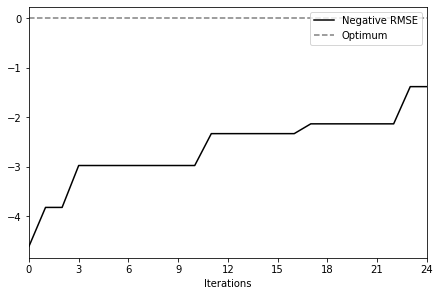

In [16]:
plot_progress(bo.Y_sample.reshape(-1), optimum=0, metric_name='Negative RMSE')
plt.show()

In [17]:
print(f"""Learning rate (const): {best_para_my[0]:.4f}
Learning rate (growth): {best_para_my[1]:.4f}
Leafes: {int(best_para_my[2])}""")

Learning rate (const): 0.0955
Learning rate (growth): 0.9239
Leafes: 665


Perform Bayesian Optimization using Facebooks Ax platform

In [18]:
# Initiate model
mdl = Model(data_mat, lags, n_oos, n_val, prediction_range, 
            target_vars_inds, params)

# Define lower and upper bounds for the variables
search_space = SearchSpace(parameters=[
        RangeParameter(name="lr", lower=1.0e-5, upper=1.0e-1,     
                               parameter_type=ParameterType.FLOAT),
        RangeParameter(name="lr_change", lower=0.5, upper=1.0,    
                               parameter_type=ParameterType.FLOAT),    
        RangeParameter(name="leafes", lower=2, upper=1000,    
                               parameter_type=ParameterType.INT)]
    )

# Initiate Experiment
experiment = SimpleExperiment(
    name = f"weather_lbgm_{dt.datetime.today().strftime('%d-%m-%Y')}",
    search_space = search_space,
    evaluation_function = mdl.obj_fun,
)

# Initiate Bayesian Optimization with random draws
sobol = Models.SOBOL(experiment.search_space)
for i in range(n_random_trials):
    experiment.new_trial(generator_run=sobol.gen(1))

# Run Bayesian Optimization
best_arm = None
for i in range(n_searches):
    gpei = Models.GPEI(experiment=experiment, data=experiment.eval())
    generator_run = gpei.gen(1)
    best_arm, _ = generator_run.best_arm_predictions
    if i < n_searches-1:
        experiment.new_trial(generator_run=generator_run)

best_para_ax = best_arm.parameters

C:\Users\tobia\anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

C:\Users\tobia\anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument

C:\Users\tobia\anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

C:\Users\tobia\anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument

C:\Users\tobia\anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

C:\Users\tobia\anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument

C:\Users\tobia\anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning:

Found `num

Plot the optimization process 

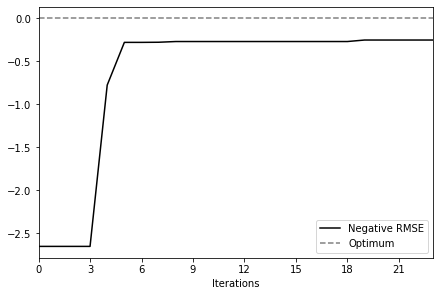

In [19]:
ax_progress = np.array([i.objective_mean for i in experiment.trials.values()])
plot_progress(ax_progress, optimum=0, metric_name='Negative RMSE')
plt.show()

In [20]:
print(f"""Learning rate (const): {best_para_ax['lr']:.4f}
Learning rate (growth): {best_para_ax['lr_change']:.4f}
Leafes: {int(best_para_ax['leafes'])}""")

Learning rate (const): 0.1000
Learning rate (growth): 1.0000
Leafes: 339


Use the best parameters for the final calculation

In [21]:
n_oos = 0
params['num_boost_round'] = 200
mdl = Model(data_mat, lags, n_oos, n_val, prediction_range, target_vars_inds, params)
mdl.fit(best_para_ax)
X_pred = mdl.standing_forecast()

C:\Users\tobia\anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

C:\Users\tobia\anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



In [22]:
df_plot = pd.DataFrame([df_train.iloc[0,:6].to_numpy(), X_pred[:,0], 
                        df_train.iloc[1,:6].to_numpy(),X_pred[:,1]], 
                       columns = pd.Index(df_train.columns[:6], name='Date'),
                       index = pd.MultiIndex.from_product([['Temperature','Rain'], 
                                                           ['Target','Forecast']],
                                                          names=['variable', 'kind'])
                      ).T.unstack().reset_index()
df_plot.rename(columns={0:'val'}, inplace=True)

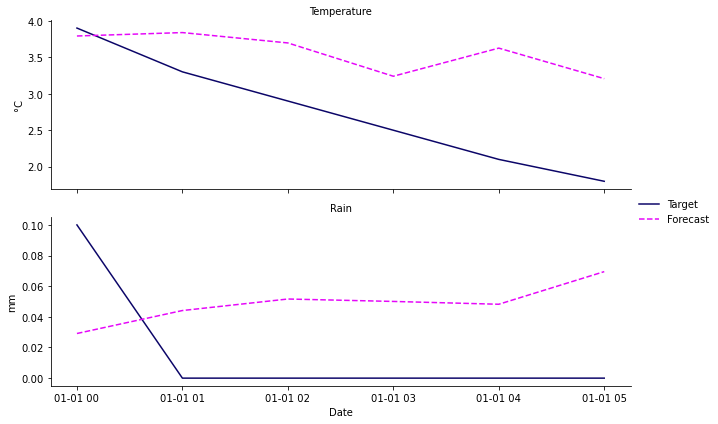

In [23]:
plt.rcParams['figure.constrained_layout.use'] = False
kw = {'color': ['#0b0568', '#e507f9'], 
      'linestyle' : ['-','--']}

g = sns.FacetGrid(df_plot, row='variable', hue='kind', 
                  hue_kws=kw, sharey=False, aspect=3)
g.map(sns.lineplot, 'Date', 'val')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend(title='')
g.axes[0,0].set_ylabel('°C')
g.axes[1,0].set_ylabel('mm')

plt.show()